# Goal

See if trading cryptos which are shift-correlated BTCUSDT is profitable

So far:
- a few stocks are certainly shift-correlated

- taker's fee wipes out profits for most simple strategies (even with a threshold) for OSMO

To test
- simple taker strategies (take when expected profit > 2*fees)
- take and hold (take, but only change position when expected pnl change > fees)
- market making strategies

pnl attribution:
- how much from fees?
- how much from desired position?
- how much from holding undesired position?
- how much would spread affect pnl?

# Steps

Components of a backtest
- choose a signal (BTC returns, combination of returns, etc)
- use signal --> predicted returns for a specific stock
- take position based on predicted returns, fees, spread, etc. (only take position if predicted returns > cost of getting position)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
df = pd.read_csv('./5min_data.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()
print("Daterange:", df.index[0], df.index[-1])

Daterange: 2024-09-01 00:00:00 2024-11-21 19:00:00


In [ ]:
# From FindStocks, prepare df
start_train  = datetime(2024, 9, 1)
end_train = datetime(2024, 10, 31)
end_test = datetime(2024, 11, 21, 19)
train_df = df.loc[start_train:end_train]
test_df = df.loc[end_train + timedelta(hours=1):end_test]

def getReturnDf(data):
    temp = data.dropna(how='any', axis=1)

    # Get most stock returns
    stocks = [colName.split('_')[0] for colName in temp.columns]

    for stock in stocks:
        temp[f'{stock}_return'] = (temp[f'{stock}_close'] - temp[f'{stock}_close'].shift(1))/temp[f'{stock}_close'].shift(1)

    # Get indicator returns, shifted extra
    indicators = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
    for indicator in indicators:
        temp[f'{indicator}_prev_return'] = temp[f'{indicator}_return'].shift(1)

    return_df = temp.filter(regex='return$')
    return_df = return_df.drop(labels=return_df.index[:2], axis=0)
    return return_df

train_returns = getReturnDf(train_df)
test_returns = getReturnDf(test_df)

In [43]:
# Visualizations to find a proper utility function
import statsmodels.api as sm

def findUtility(df, stock):
    X = df['BTCUSDT_prev_return']
    model = sm.OLS(df[f'{stock}_return'], X).fit()
    print(model.summary())

    # predictions = model.predict(X)
    # df['residuals'] = df[f'{stock}_return'] - predictions
    # bins = np.arange(-0.010, 0.01001, 0.0005)
    # df['BTCUSDT_prev_return_binned'] = pd.cut(df['BTCUSDT_prev_return'], bins=bins)
    # sns.boxplot(data=df, x='BTCUSDT_prev_return_binned', y='residuals')
    # sns.regplot(data=df, x='BTCUSDT_prev_return', y=f'{stock}_return', scatter_kws = {'alpha': 0.01}, order=3)

findUtility(train_returns, 'ETHFIPERP')

                                 OLS Regression Results                                
Dep. Variable:       ETHFIPERP_return   R-squared (uncentered):                   0.040
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              710.6
Date:                Fri, 22 Nov 2024   Prob (F-statistic):                   1.87e-153
Time:                        21:15:45   Log-Likelihood:                          72307.
No. Observations:               17231   AIC:                                 -1.446e+05
Df Residuals:                   17230   BIC:                                 -1.446e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

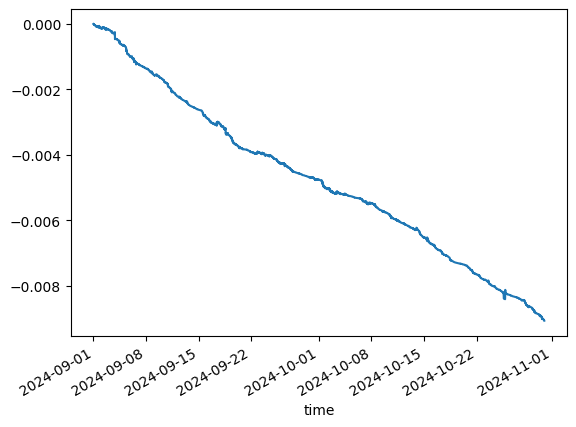

In [69]:
# Backtest
class Backtest:
    def __init__(self, data, x, y):
        self.df = data
        self.x = x # usually BTC prevReturn
        self.y = y # usually new stock returns
    
    def calculatePositions(self, predictionFunction, positionFunction):
        self.df['predicted_returns'] = predictionFunction(self.df[self.x]) # return in decimal form
        self.df['position'] = 0.0
        fee = 0.0002

        for i in range(1, len(self.df.index)):
            prev_position = self.df['position'].iloc[i-1]
            pred_return = self.df.loc[self.df.index[i],'predicted_returns']
            if abs(pred_return - prev_position) > fee:
                self.df.loc[self.df.index[i], 'position'] = pred_return
            # take a position of 1 or -1. 1 if predicted returns

            # take position=predicted_returns if (last position > fees)
    
    def graph_pnl(self):
        self.df['pnl'] = self.df['position'] * self.df[self.y].shift(-1)
        self.df['fees'] = abs(self.df['position'] - self.df['position'].shift(1))*0.00055
        self.df['cumpnl'] = (self.df['pnl'] - self.df['fees']).cumsum()

        self.df['cumpnl'].plot()

b = Backtest(train_returns, x='BTCUSDT_prev_return', y='OSMOUSDT_return')
b.calculatePositions(predictionFunction= lambda x:x)
b.graph_pnl()

In [65]:
b.df[['BTCUSDT_prev_return', 'OSMOUSDT_return', 'predicted_returns', 'position', 'pnl', 'cumpnl']].head(30)

,BTCUSDT_prev_return,OSMOUSDT_return,predicted_returns,position,pnl,cumpnl
time,,,,,,
2024-09-01 00:10:00,0.000496,0.000512,0.000496,-0.000951,7.290136e-07,NaN
2024-09-01 00:15:00,0.000464,-0.000767,0.000464,0.000734,0.000000e+00,-9.266533e-07
2024-09-01 00:20:00,-0.000951,0.000000,-0.000951,0.000862,0.000000e+00,-9.969005e-07
2024-09-01 00:25:00,0.000734,0.000000,0.000734,0.000767,-3.925267e-07,-1.441523e-06
2024-09-01 00:30:00,0.000862,-0.000512,0.000862,0.000000,0.000000e+00,-1.863479e-06
2024-09-01 00:35:00,0.000767,0.001024,0.000767,0.000000,0.000000e+00,-1.863479e-06
2024-09-01 00:40:00,-0.000504,0.000000,-0.000504,-0.001545,-0.000000e+00,-2.713259e-06
2024-09-01 00:45:00,-0.000531,0.000000,-0.000531,0.000000,0.000000e+00,-3.563038e-06
2024-09-01 00:50:00,-0.001545,0.000000,-0.001545,0.000000,0.000000e+00,-3.563038e-06
